In [6]:
import yfinance as yf
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import warnings
warnings.filterwarnings('ignore')

# ✅ 한글 폰트 설정
def set_korean_font():
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = fm.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    # 한글 폰트 적용
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

# ✅ 주가 데이터 불러오기
def load_stock_data(ticker, months=18):
    today = date.today()
    startD = today - relativedelta(months=months)
    endD = today
    return yf.download(ticker, startD, endD)

# ✅ 수익률 평균과 표준편차 계산
def calc_return_stats(stock_data):
    returns = stock_data['Close'].pct_change().dropna()
    mu = returns.mean()
    sigma = returns.std()
    return mu, sigma

In [16]:

# ✅ 몬테카를로 시뮬레이션
def run_loss_simulations( ticker, num_simulations=100, T=252, lambda_event=0.13, jump_mu=-0.01, jump_vol=0.045, trigger_rate=0.05, epsilon = 0.006 ):
    print(f"""
    시뮬레이션 입력값:
    - 종목코드: {ticker}
    - 시뮬레이션 횟수: {num_simulations}회
    - 시뮬레이션 기간: {T}일
    - 연간 점프 발생률(λ): {lambda_event*252:.3f}회
    - 점프 크기 평균(μ): {jump_mu:.3%}
    - 점프 크기 변동성(σ): {jump_vol:.3%}
    - 트리거 비율: {trigger_rate:.1%}
    - 일일 보험료율: {epsilon:.3%}
    """)
    df = pd.DataFrame()
    last_price_list = []
    jump_indices_list = []  # 점프 발생 인덱스 리스트 
    count_jump = []
    insurance_payments = []  # 보험금 지급 리스트
    insurance_premiums = []  # 보험료 납입 리스트
    lambda_event = lambda_event / 252
    
    KOFR = 0.0258     # KOFR 2.581%
    i = KOFR / 252
    
    stock_data = load_stock_data(ticker)
    last_price = int(stock_data['Close'].iloc[-1])
    mu, daily_vol = calc_return_stats(stock_data)

    for _i_ in range(num_simulations):
        count = 0
        price_list = []
        price = int(last_price * (1 + np.random.normal(mu, daily_vol)))
        price_list.append(price)
        jump_indices = []  # 각 시뮬레이션별 점프 인덱스
        insurance_payment = 0  # 보험금 지급액
        insurance_premium = 0  # 보험료 납입액
        trigger_price = None  # 트리거 가격
        triggered = False

        for t in range(T):
            if not triggered:  # 보험금 수령 전까지만 보험료 납입
                temp = last_price * epsilon / 252# 일일 보험료 납입
                insurance_premium += temp * (1 + i) ** -t
                
            if triggered:
                price = trigger_price
            else:
                event = np.random.poisson(lambda_event)
                if event >= 1:
                    jump_return = np.random.normal(jump_mu , jump_vol)
                    price_before_jump = price_list[count]
                    trigger_price = int(price_before_jump * (1 - trigger_rate))
                    price = int(price_before_jump * (1 - abs(jump_return)))
                    
                    # 포아송 하락 점프로 인해 트리거 가격 이하로 떨어진 경우
                    if jump_return < 0 and price < trigger_price:
                        insurance_payment = trigger_price - price  # 손실액 보전
                        print(f'sim{_i_}에서 {t}일차에 보험금 지급발생!: {insurance_payment}')
                        price = trigger_price  # 보험금 지급 후 가격은 트리거 가격
                        triggered = True
                    jump_indices.append(count)
                else:
                    price =int(price_list[count] * (1 + np.random.normal(mu, daily_vol)))
            
            price_list.append(price)
            count += 1

        df[len(df.columns)] = price_list
        last_price_list.append(price_list[-1])
        jump_indices_list.append(jump_indices)
        count_jump.append(len(jump_indices))
        insurance_payments.append(insurance_payment)
        insurance_premiums.append(insurance_premium)

    return ticker, df, last_price_list, jump_indices_list, count_jump, insurance_payments, insurance_premiums


In [22]:
# ✅ 메인 함수 (종목코드 ticker를 인자로 받음)
def viz_loss(ticker, params):

    # 시뮬레이션 실행
    _, price_df, last_price_list, jump_indices_list, count_jump, insurance_payments, insurance_premiums = run_loss_simulations(
        ticker=ticker,
        num_simulations=params['num_simulations'], 
        T=params['T'], 
        lambda_event=params['lambda_event'], 
        jump_mu=params['jump_mu'], 
        jump_vol=params['jump_vol'],
        trigger_rate=params['trigger_rate'], 
        epsilon=params['epsilon'])

    
    set_korean_font()
    



    
    
    # 보험금 분포 시각화 및 통계량 계산
    plt.figure(figsize=(8, 6))
    # array 형태의 값을 int로 변환
    payments = [int(p[0]) if isinstance(p, np.ndarray) else p for p in insurance_payments]
    # 95% VaR, 99% VaR 계산 (상위 5%, 1%)
    var_95 = np.percentile(payments, 95)   # 상위 5% 지점
    var_99 = np.percentile(payments, 99)   # 상위 1% 지점

    # 평균과 분산 계산
    mean_payment = np.mean(payments)
    var_payment = np.var(payments)
    
    # 서브플롯 생성
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # 왼쪽 그래프 - 전체 데이터
    ax1.boxplot(payments, widths=0.7)
    ax1.axhline(mean_payment, color='r', linestyle='dashed', linewidth=1, label=f'평균: {mean_payment:,.0f}원')
    ax1.set_title('전체 보험금 분포', fontsize=14)
    ax1.set_ylabel('Insurance Payment (KRW)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 오른쪽 그래프
    filtered_payments = payments # [p for p in payments if p != 0] > 0인 부분 제외할 때 이거 쓰기기
    ax2.hist(filtered_payments, bins=20)
    filtered_mean = np.mean(filtered_payments)
    ax2.axvline(filtered_mean, color='r', linestyle='dashed', linewidth=1, label=f'평균: {filtered_mean:,.0f}원')
    # VaR을 그래프에 표시
    ax1.axhline(var_95, color='g', linestyle='dotted', linewidth=1, label=f'95% VaR: {var_95:,.0f}원')
    ax1.axhline(var_99, color='b', linestyle='dotted', linewidth=1, label=f'99% VaR: {var_99:,.0f}원')
    # VaR을 그래프에 표시
    ax2.axvline(var_95, color='g', linestyle='dotted', linewidth=1, label=f'95% VaR: {var_95:,.0f}원')
    ax2.axvline(var_99, color='b', linestyle='dotted', linewidth=1, label=f'99% VaR: {var_99:,.0f}원')
    ax2.set_title('보험금 분포', fontsize=14)
    ax2.set_xlabel('Insurance Payment (KRW)', fontsize=12)
    ax2.set_ylabel('빈도 수', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    
    # 베이시스 리스크 측정을 위한 파이 차트
    plt.figure(figsize=(8, 6))
    
    # 보험금 수령자와 미수령자 계산
    received = sum(1 for p in payments if p > 0)
    not_received = len(payments) - received
    
    # 데이터와 레이블 준비
    sizes = [received, not_received]
    labels = [f'보험금 수령\n({received/len(payments)*100:.1f}%)', 
              f'보험금 미수령\n({not_received/len(payments)*100:.1f}%)']
    colors = ['lightcoral', 'lightblue']
    
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=90)
    plt.title('베이시스 리스크 측정\n(보험금 수령 여부 분포)', fontsize=14)
    plt.axis('equal')
    plt.show()
    
    # 평균 보험료와 평균 보험금 비교 시각화
    plt.figure(figsize=(12, 6))


    # 데이터 준비
    mean_premium = np.mean(insurance_premiums)
    categories = ['평균 보험료', '평균 보험금']
    values = [mean_premium, mean_payment]

    # 막대 그래프 생성
    bars = plt.bar(categories, values, color=['lightblue', 'lightcoral'])

    # 막대 위에 값 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}원',
                ha='center', va='bottom')

    plt.title('평균 보험료와 평균 보험금 비교', fontsize=14)
    plt.ylabel('금액 (KRW)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # 손해율 계산 및 표시
    loss_ratio = (mean_payment / mean_premium) * 100
    plt.text(0.5, max(values) * 1.1, 
            f'손해율: {loss_ratio:.1f}%',
            ha='center', fontsize=12)
    plt.show()

[*********************100%***********************]  1 of 1 completed


    시뮬레이션 입력값:
    - 종목코드: 005930.KS
    - 시뮬레이션 횟수: 1000회
    - 시뮬레이션 기간: 1260일
    - 연간 점프 발생률(λ): 32.760회
    - 점프 크기 평균(μ): -1.250%
    - 점프 크기 변동성(σ): 9.090%
    - 트리거 비율: 10.0%
    - 일일 보험료율: 0.125%
    


sim2에서 985일차에 보험금 지급발생!: 10023
sim5에서 223일차에 보험금 지급발생!: 403
sim8에서 48일차에 보험금 지급발생!: 3381
sim18에서 414일차에 보험금 지급발생!: 2876
sim23에서 207일차에 보험금 지급발생!: 435
sim24에서 198일차에 보험금 지급발생!: 4907
sim46에서 845일차에 보험금 지급발생!: 874
sim51에서 1119일차에 보험금 지급발생!: 556
sim66에서 594일차에 보험금 지급발생!: 4417
sim80에서 1227일차에 보험금 지급발생!: 983
sim103에서 1236일차에 보험금 지급발생!: 984
sim106에서 813일차에 보험금 지급발생!: 833
sim109에서 316일차에 보험금 지급발생!: 6040
sim127에서 651일차에 보험금 지급발생!: 8744
sim139에서 49일차에 보험금 지급발생!: 1754
sim141에서 22일차에 보험금 지급발생!: 3396
sim148에서 415일차에 보험금 지급발생!: 3057
sim151에서 462일차에 보험금 지급발생!: 886
sim157에서 464일차에 보험금 지급발생!: 6072
sim160에서 127일차에 보험금 지급발생!: 4062
sim170에서 168일차에 보험금 지급발생!: 5475
sim175에서 726일차에 보험금 지급발생!: 194
sim181에서 234일차에 보험금 지급발생!: 4161
sim192에서 883일차에 보험금 지급발생!: 1650
sim196에서 126일차에 보험금 지급발생!: 907
sim210에서 743일차에 보험금 지급발생!: 293
sim237에서 1259일차에 보험금 지급발생!: 1408
sim246에서 1210일차에 보험금 지급발생!: 2991
sim248에서 124일차에 보험금 지급발생!: 2798
sim269에서 1062일차에 보험금 지급발생!: 200
sim270에서 288일차에 보험금 지급발생!: 4635
sim275에서 215일차에 보험금 지급발생!: 40

<Figure size 800x600 with 0 Axes>

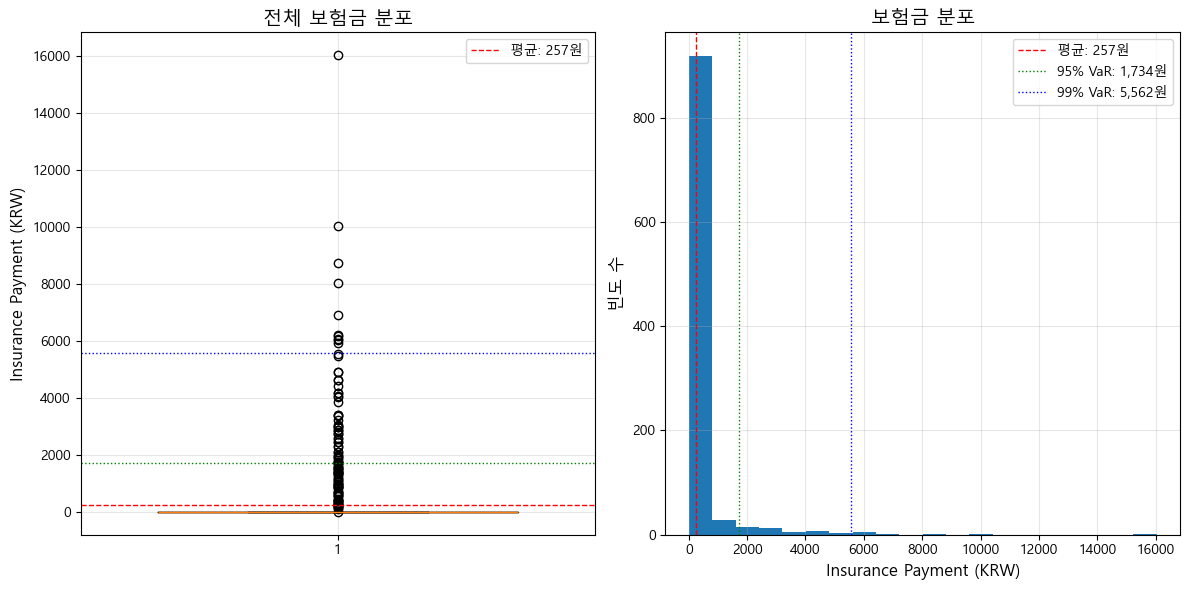

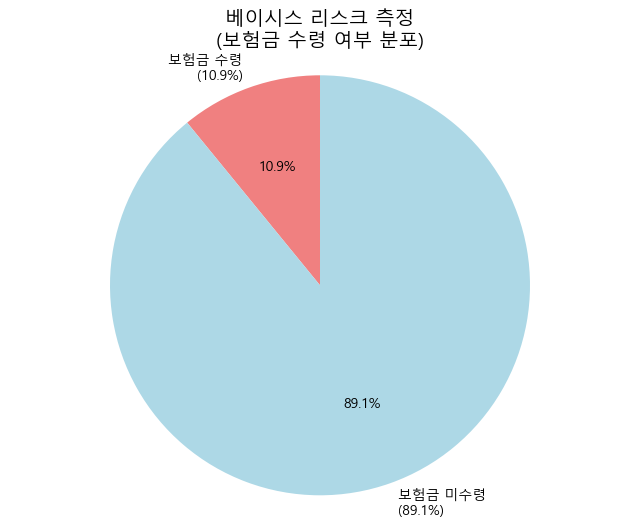

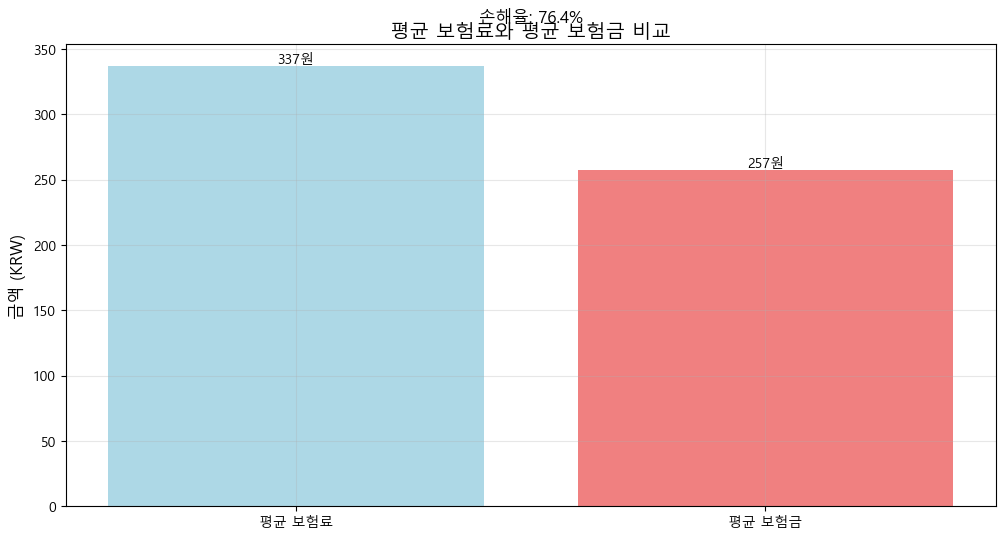

In [23]:
# 시뮬레이션 파라미터 설정
params = {
    'num_simulations': 1000,  # 시뮬레이션 횟수
    'T': 252*5,               # 시뮬레이션 기간(거래일)
    'lambda_event': 0.13,   # 점프 발생 확률
    'jump_mu': -0.0125,       # 점프 크기의 평균 : 10일 평균
    'jump_vol': 0.0909,      # 점프 크기의 표준편차
    'trigger_rate': 0.10,   # 트리거 수익률
    'epsilon': 0.00125        # 보험요율
}


viz_loss('005930.KS', params)